In [1]:
from DeterministicLotkaVolterra import DeterministicLotkaVolterra
import sys
sys.path.append('../')
from MCMCSamplers import AdaptiveMetropolisSampler, GaussianProposal
import numpy as np
from scipy.optimize import minimize
import scipy.io

In [2]:
# define model
T = 20;
LV = DeterministicLotkaVolterra(T)

# load data for inference
data = scipy.io.loadmat('problem_data.mat')
xtrue = data['xtrue'][0,:]
tt = np.linspace(0,LV.T,1000)
yobs = data['yobs']
ytrue = LV.simulate_ode(xtrue, tt)
_, tobs = LV.sample_data(xtrue)
#x_samps = data['x_samps']

### Run Baseline MCMC

In [3]:
# define target density and bounds
class Posterior():
    def __init__(self, yobs):
        self.yobs = yobs
    def logpdf(self, x):
        if len(x.shape) == 1:
            x = x.reshape((1,LV.d))
        return LV.log_likelihood(x, self.yobs) + LV.log_prior_pdf(x)
pi = Posterior(yobs[0,:])
bounds = np.array([[0.]*LV.d,[np.inf]*LV.d])

# find MAP point
x0 = xtrue
neg_post = lambda x : -1*pi.logpdf(x)
xmap = minimize(neg_post, x0)

print(xtrue)
print(xmap.x)

[0.83194674 0.04134147 1.0823151  0.03991483]
[0.80942424 0.03694719 1.12825981 0.04572161]


In [4]:
# define Gaussian proposal
prop_std = 0.1;
prop = GaussianProposal(cov=prop_std**2*np.eye(LV.d));

# run MCMC
n_steps = int(1e5)
mcmc = AdaptiveMetropolisSampler(pi, prop)
x_samps, logpdf_samps = mcmc.sample(xmap.x, n_steps, bounds)

  0%|                                                                    | 0/100000 [00:00<?, ?it/s]/opt/anaconda3/envs/ML/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|######################################################| 100000/100000 [09:22<00:00, 177.81it/s]

Overall acceptance rate: 31.5



### Load MGAN

In [5]:
## Define parameters
hidden_dim = 128
normalize = 1
import torch
import scipy.io
import sys
sys.path.append('../../')
from utilities import UnitGaussianNormalizer
device = torch.device('cpu')

# load data
data = scipy.io.loadmat('training_data.mat')
x_train = torch.tensor(data['x_train'])
y_train = torch.tensor(data['y_train'])

#normalize inputs
if normalize == 1:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    y_normalizer = UnitGaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)

# sample prior/data
y_in = torch.tensor(yobs).reshape((1,yobs.shape[1]))

# normalize y
if normalize == 1:
    y_in = y_normalizer.encode(y_in)

# determine reference dimension
z_dim = x_train.shape[1]
y_dim = y_train.shape[1]

# define and load network
from wgan import Generator, get_noise
gen = Generator(input_dim=z_dim+y_dim, output_dim=z_dim, hidden_dim=hidden_dim).to(device)
file_name = 'mgan_DeterministicLotkaVolterra_mon01_gp1.0'
gen.load_state_dict(torch.load(file_name + '_gen.pt'))

# sample generator
nMC = 50000
noise = get_noise(nMC, z_dim, device=device)
y_in = y_in.repeat(nMC, 1)
z = torch.cat((y_in, noise),1).float().detach()
x_sample = gen(z).detach()

# transform samples back to un-normalized space
if normalize == 1:
    x_sample = x_normalizer.decode(x_sample)

### Compare MGAN to MCMC

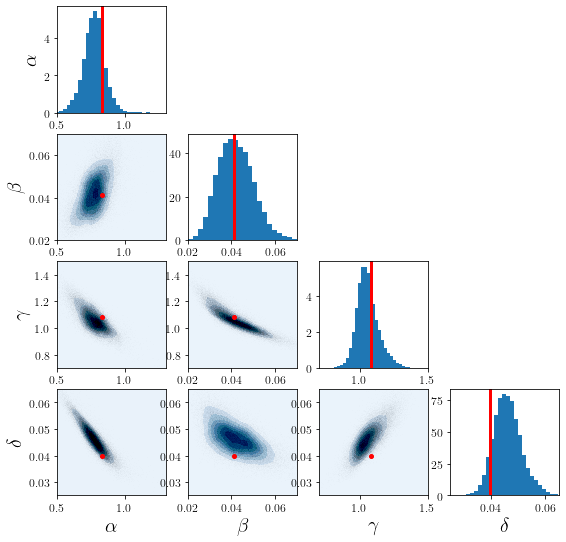

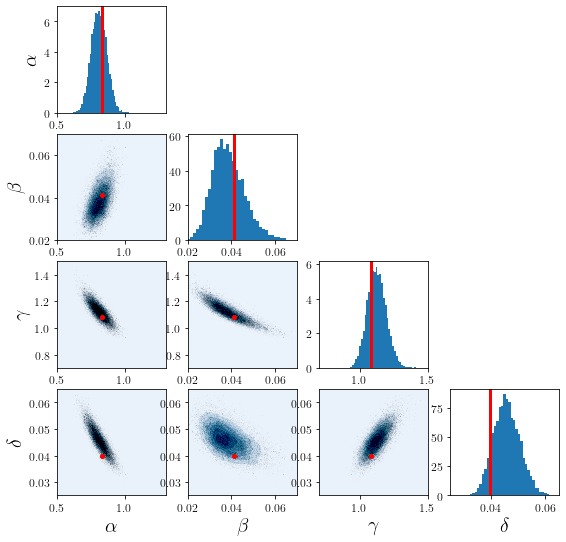

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
plt.rc('text', usetex=True)
plt.rc('font', size=12)
symbols = [r'$\alpha$',r'$\beta$',r'$\gamma$',r'$\delta$']
limits = [[0.5,1.3],[0.02,0.07],[0.7,1.5],[0.025,0.065]]

def plot_matrix(x_samps, limits, xtrue=None, symbols=None):
    dim = x_samps.shape[1]
    plt.figure(figsize=(9,9))
    for i in range(dim):
        for j in range(i+1):
            ax = plt.subplot(dim,dim,(i*dim)+j+1)
            if i==j:
                plt.hist(x_samps[:,i], bins=40, density=True)
                if xtrue is not None:
                    plt.axvline(xtrue[i], color='r', linewidth=3)
                plt.xlim(limits[i])
            else:
                plt.plot(x_samps[:,j], x_samps[:,i], '.k', markersize=.04, alpha=0.1)
                if xtrue is not None:
                    plt.plot(xtrue[j], xtrue[i], '.r', markersize=8, label='Truth')
                # Peform the kernel density estimate
                xlim = limits[j]
                ylim = limits[i]
                xx, yy = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
                positions = np.vstack([xx.ravel(), yy.ravel()])
                kernel = st.gaussian_kde(x_samps[:,[j,i]].T)
                f = np.reshape(kernel(positions), xx.shape)
                ax.contourf(xx, yy, f, cmap='Blues')
                plt.ylim(limits[i])
            plt.xlim(limits[j])
            if symbols is not None:
                if j==0:
                    plt.ylabel(symbols[i], size=20)
                if i==len(xtrue)-1:
                    plt.xlabel(symbols[j], size=20)

max_samples = 50000
plot_matrix(x_sample[:max_samples,:].detach().numpy(), limits, xtrue, symbols)
plt.savefig('DLV_MGANposterior.pdf', bbox_inches='tight')
plot_matrix(x_samps[50000:50000+max_samples,:], limits, xtrue, symbols)
plt.savefig('DLV_MCMCposterior.pdf', bbox_inches='tight')

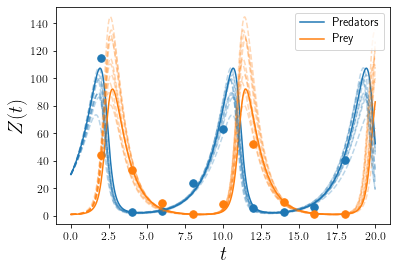

In [7]:
# plot posterior predictive
plt.figure()
c1=plt.plot(tt, ytrue[:,0], '-', label='Predators')
c2=plt.plot(tt, ytrue[:,1], '-', label='Prey')
nobs = int(yobs.size/2.)
yobs_plot = yobs.reshape((nobs,2))
plt.plot(tobs[1:], yobs_plot[:,0], '.', color=c1[0].get_color(), markersize=15)
plt.plot(tobs[1:], yobs_plot[:,1], '.', color=c2[0].get_color(), markersize=15)
for i in range(10):
    rand_sample = np.random.randint(low=50000, high=50000+max_samples, size=(1,))[0]
    yt = LV.simulate_ode(x_samps[rand_sample,:],tt)
    plt.plot(tt, yt[:,0], '--', color=c1[0].get_color(), alpha=0.3)
    plt.plot(tt, yt[:,1], '--', color=c2[0].get_color(), alpha=0.3)
plt.xlabel('$t$', size=20)
plt.ylabel('$Z(t)$', size=20)
plt.legend(loc='upper right')
plt.savefig('DLV_MCMCpredictive.pdf')

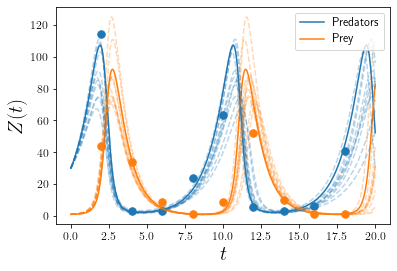

In [8]:
# plot posterior predictive
plt.figure()
c1=plt.plot(tt, ytrue[:,0], '-', label='Predators')
c2=plt.plot(tt, ytrue[:,1], '-', label='Prey')
nobs = int(yobs.size/2.)
yobs_plot = yobs.reshape((nobs,2))
plt.plot(tobs[1:], yobs_plot[:,0], '.', color=c1[0].get_color(), markersize=15)
plt.plot(tobs[1:], yobs_plot[:,1], '.', color=c2[0].get_color(), markersize=15)
for i in range(10):
    rand_sample = np.random.randint(nMC, size=(1,))[0]
    yt = LV.simulate_ode(x_sample[rand_sample,:].detach().numpy(),tt)
    plt.plot(tt, yt[:,0], '--', color=c1[0].get_color(), alpha=0.3)
    plt.plot(tt, yt[:,1], '--', color=c2[0].get_color(), alpha=0.3)    
plt.xlabel('$t$', size=20)
plt.ylabel('$Z(t)$', size=20)
plt.legend(loc='upper right')
plt.savefig('DLV_MGANpredictive.pdf')